In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

### The MLP to predict the force

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size=70, hidden_size=32, output_size=70):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

### Prepare the data set

In [13]:
def reshape_to_samples(data, sample_length=70):
    n = len(data)
    num_samples = n // sample_length  # Number of complete samples
    trimmed_data = data[:num_samples * sample_length]
    reshaped = trimmed_data.reshape((num_samples, sample_length))
    return reshaped

In [4]:
period = 140
data_in = np.load('data_in_for_predict.npy')
data_out = np.load('data_out_for_predict.npy')

# select y to train as an example
X_scaled = reshape_to_samples(data_in[:,1])
Y_scaled = reshape_to_samples(data_out[:,1])


# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

In [18]:
# First, split into training+validation and test
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.15, random_state=42
)

# Then split training+validation into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.1765, random_state=42
)

In [22]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val, Y_val)
test_dataset  = TensorDataset(X_test, Y_test)  # NEW

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)  # NEW

In [23]:
# ======= Use GPU if available =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
# ======= Initialize model, loss, optimizer =======
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# ======= Training loop with Early Stopping =======
num_epochs = 1000
best_val_loss = float('inf')
patience = 20        # stop if no improvement for 20 epochs
wait = 0             # epochs since last improvement

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

    # ======= Validation =======
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, Y_batch).item()
        val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}")

    # ======= Check Early Stopping Condition =======
    if val_loss < best_val_loss - 1e-5:  # small threshold to detect actual improvement
        best_val_loss = val_loss
        wait = 0
        best_model_state = model.state_dict()  # save best model
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}, best val loss: {best_val_loss:.6f}")
            break

# ======= Load best model =======
model.load_state_dict(best_model_state)

# ======= Confirm device =======
print("Model on:", next(model.parameters()).device)

Epoch 1/1000, Validation Loss: 1.069920
Epoch 2/1000, Validation Loss: 1.014269
Epoch 3/1000, Validation Loss: 0.935174
Epoch 4/1000, Validation Loss: 0.820387
Epoch 5/1000, Validation Loss: 0.660896
Epoch 6/1000, Validation Loss: 0.459950
Epoch 7/1000, Validation Loss: 0.261328
Epoch 8/1000, Validation Loss: 0.142040
Epoch 9/1000, Validation Loss: 0.106248
Epoch 10/1000, Validation Loss: 0.075876
Epoch 11/1000, Validation Loss: 0.055013
Epoch 12/1000, Validation Loss: 0.050399
Epoch 13/1000, Validation Loss: 0.048239
Epoch 14/1000, Validation Loss: 0.047117
Epoch 15/1000, Validation Loss: 0.046863
Epoch 16/1000, Validation Loss: 0.046100
Epoch 17/1000, Validation Loss: 0.045592
Epoch 18/1000, Validation Loss: 0.044979
Epoch 19/1000, Validation Loss: 0.044622
Epoch 20/1000, Validation Loss: 0.044067
Epoch 21/1000, Validation Loss: 0.043659
Epoch 22/1000, Validation Loss: 0.043670
Epoch 23/1000, Validation Loss: 0.042670
Epoch 24/1000, Validation Loss: 0.042231
Epoch 25/1000, Validation

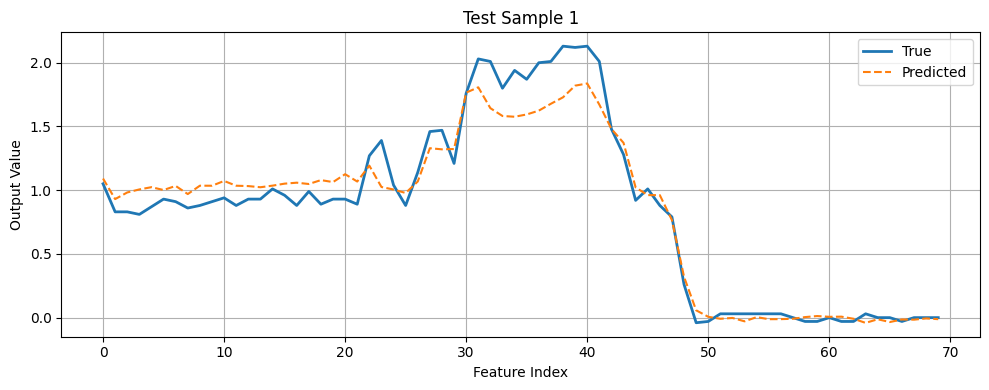

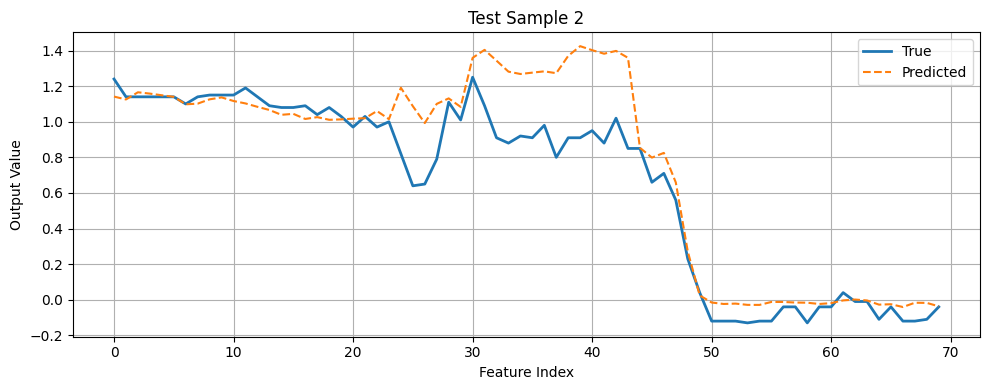

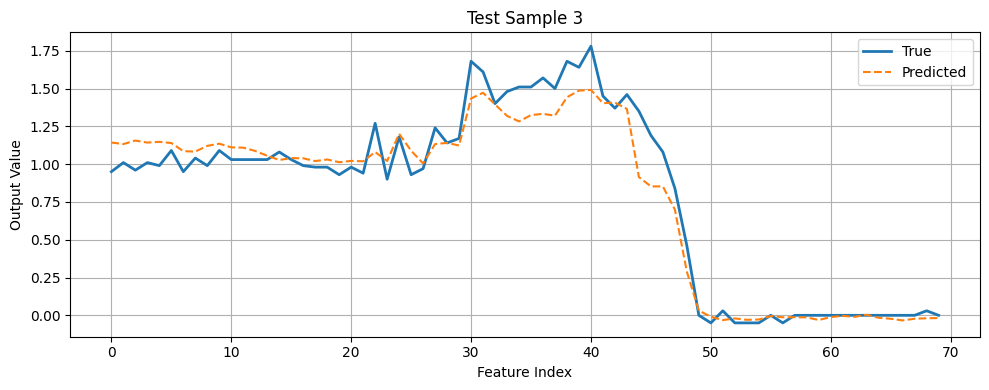

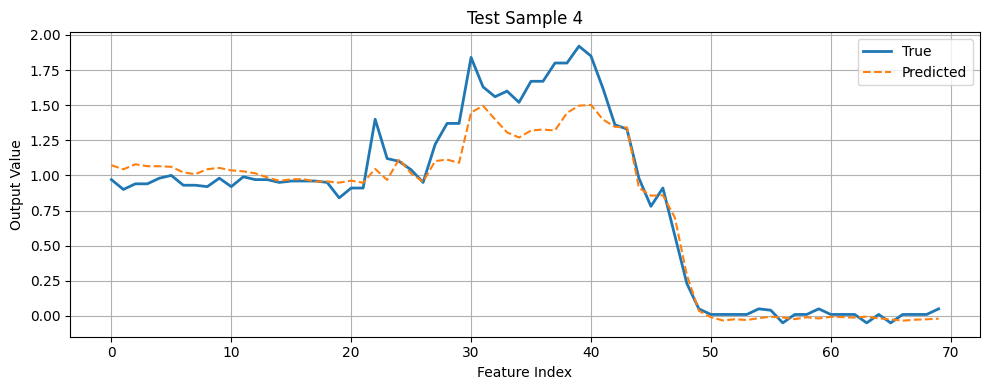

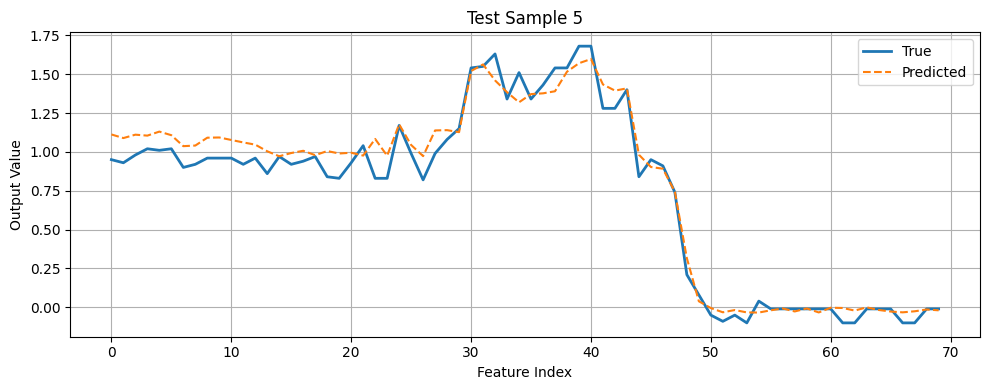

In [47]:
# ======= Evaluate on Test Set =======
model.eval()
with torch.no_grad():
    X_test_gpu = X_test.to(device)
    Y_test_gpu = Y_test.to(device)
    predictions = model(X_test_gpu).cpu().numpy()
    true_vals = Y_test_gpu.cpu().numpy()


# ======= Plotting Predicted vs. True for First Few Test Samples =======
n_samples_to_plot = 5  # or any number ≤ len(X_test)
for i in range(n_samples_to_plot):
    plt.figure(figsize=(10, 4))
    plt.plot(true_vals[i], label="True", linewidth=2)
    plt.plot(predictions[i], label="Predicted", linestyle='--')
    plt.title(f"Test Sample {i+1}")
    plt.xlabel("Feature Index")
    plt.ylabel("Output Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
# Save the model state_dict
torch.save(model.state_dict(), "RF_limb_MLP.pth")
print("save the model RF_limb_MLP.pth")

save the model RF_limb_MLP.pth
